In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

random_seed_number = 45
np.random.seed(random_seed_number)

# Specify the file path
file_path = "<file path to the experiemntal data>"

# Read the data from the 'batch1' sheet into a pandas DataFrame
data = pd.read_excel(file_path, sheet_name="batch1")

# Display the first few rows to check if the data was loaded correctly
print(data.head())

                     exp      对位选择性      间位选择性      邻位选择性     ton
0  1-I,F,Y,G,K,V,A,N,M,D  20.475293  33.274272  46.250436   6.969
1  2-L,V,Q,Y,K,N,C,F,P,E  21.367940  31.454554  47.177505   4.455
2  3-N,E,I,G,K,Y,I,V,N,Y  21.722533  32.787287  45.490180   2.721
3  4-D,E,T,I,K,I,Q,Y,A,M  20.138117  32.318466  47.543417  12.690
4  5-N,Q,I,Q,K,P,Y,V,D,Y  21.499640  30.798048  47.702312   4.267


In [3]:
X = np.array(
    [i.replace("-重复", "").split("-")[1].split(",") for i in data["exp"]]
)  # 把重复数据的“重复”删除，拆分为列表

y = data["ton"].values

unique_X = np.unique(X, axis=0)  # x=多肽序列并去重
average_Y = np.array(
    [y[(X == val).all(axis=1)].mean() for val in unique_X]
    )  # y平均

[['A' 'A' 'D' ... 'R' 'G' 'N']
 ['A' 'E' 'M' ... 'Y' 'M' 'M']
 ['A' 'F' 'F' ... 'C' 'I' 'C']
 ...
 ['W' 'T' 'G' ... 'C' 'Q' 'N']
 ['W' 'T' 'G' ... 'C' 'Q' 'N']
 ['Y' 'M' 'M' ... 'M' 'M' 'K']]
[ 5.374      11.02        8.409       8.512      10.176       7.43
 15.53        8.322       3.977       2.887       3.561      11.052
 12.007       5.29        5.954      14.344       5.599      10.562
 16.389      13.156      10.936      10.083      15.623      15.019
 17.494      17.41757389 16.078      19.292      22.509      18.384
 16.30264043  3.503       1.018       2.499      12.69       12.085
 11.843       9.904      17.22       24.05        6.877       2.488
  8.795      12.341      13.094       6.909      16.796       6.791
  7.415       3.556       2.211       6.31       19.589       4.708
 15.97       18.331      17.046      12.637      12.134       6.436
  3.963      24.505      21.439      12.283       2.906       6.1
 17.578      11.585      10.882       6.084       4.825       8

In [3]:
import torch
import esm

torch.manual_seed(random_seed_number)

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model = model.cuda()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [(f"protein{count}", "".join(unique_X[count])) for count in range(len(unique_X))]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens.cuda(), repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(
        token_representations[i, 1 : tokens_len - 1].mean(0).cpu()
    )

In [4]:
Xs = np.array(sequence_representations)
ys = average_Y

In [5]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    Xs, ys, train_size=train_size, random_state=random_seed_number
)

In [6]:
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((179, 1280), (45, 1280), 179, 45)

In [7]:
num_pca_components = 30
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

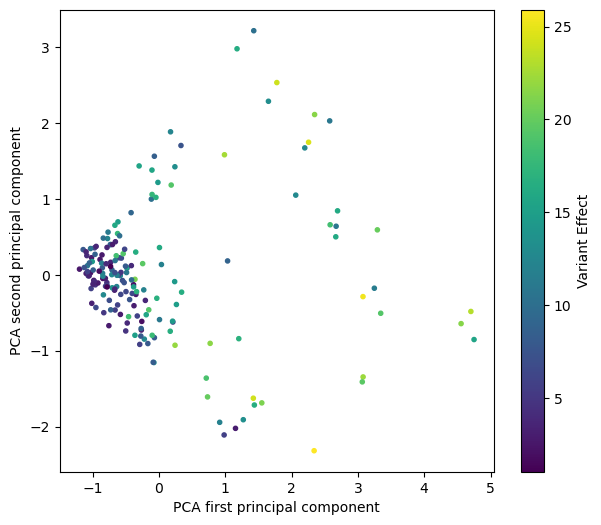

In [9]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:, 0], Xs_train_pca[:, 1], c=ys_train, marker=".")
ax.set_xlabel("PCA first principal component")
ax.set_ylabel("PCA second principal component")
plt.colorbar(sc, label="Variant Effect")

In [10]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import r2_score, mean_squared_error
best_modesl = []

for i in range(10):

    X_train, X_test, y_train, y_test = train_test_split(
        Xs_train, ys_train, test_size=0.2, random_state=123 + i
    )


    clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    display(predictions)
    
    # get the best model for now 
    best_model = clf.models[predictions.index[-1]]
    # calculate the metric 
    r2 = r2_score(ys_test, best_model.predict(Xs_test))
    RMSE =np.sqrt(
            mean_squared_error(
                ys_test, best_model.predict(Xs_test)
            )
        )
    # if r2 is larger than 0.2, append the models
    if r2>0.2:
        best_modesl.append(best_model)
        
    display(r2,RMSE)

100%|██████████| 42/42 [00:50<00:00,  1.21s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63143
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 11.042920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,230725206448223322112.00,-8207225200801087488000.00,489320545759.61,0.03
KernelRidge,1.14,-4.13,12.23,0.08
GaussianProcessRegressor,1.10,-2.64,10.31,0.26
OrthogonalMatchingPursuit,1.08,-1.95,9.28,0.04
ExtraTreeRegressor,1.04,-0.38,6.35,0.05
DecisionTreeRegressor,1.04,-0.26,6.06,0.19
DummyRegressor,1.03,-0.18,5.86,0.02
QuantileRegressor,1.03,-0.14,5.78,0.20
HuberRegressor,1.03,0.11,5.11,0.18


0.5702853431894029

3.110721058247206

100%|██████████| 42/42 [00:48<00:00,  1.16s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63149
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 10.683794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,509942729868359958528.00,-18139391391031661428736.00,803087788176.66,0.04
Lars,1958043.52,-69650368.79,49763.78,0.87
GaussianProcessRegressor,1.11,-2.93,11.82,0.04
KernelRidge,1.09,-2.37,10.95,0.03
OrthogonalMatchingPursuit,1.06,-1.16,8.76,0.04
DummyRegressor,1.03,-0.01,5.98,0.02
QuantileRegressor,1.03,-0.00,5.96,0.17
ExtraTreeRegressor,1.03,0.03,5.86,0.06
DecisionTreeRegressor,1.02,0.16,5.45,0.13


0.2898941567769052

3.9988261997254075

100%|██████████| 42/42 [00:47<00:00,  1.12s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63162
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 10.598388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,680553545254153355264.00,-24208261824040597979136.00,973896905844.09,0.03
OrthogonalMatchingPursuit,1.14,-3.85,13.79,0.03
GaussianProcessRegressor,1.11,-2.84,12.26,0.06
KernelRidge,1.10,-2.44,11.61,0.03
ExtraTreeRegressor,1.03,-0.21,6.89,0.06
QuantileRegressor,1.03,-0.01,6.29,0.16
DummyRegressor,1.03,-0.00,6.26,0.02
DecisionTreeRegressor,1.03,0.05,6.12,0.16
NuSVR,1.02,0.38,4.92,0.03


0.46073611112306845

3.484750229439839

100%|██████████| 42/42 [00:44<00:00,  1.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63161
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 10.552578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,1109983808424681406464.00,-39483709756820812726272.00,1173396103477.74,0.03
GaussianProcessRegressor,1.12,-3.30,12.25,0.04
OrthogonalMatchingPursuit,1.10,-2.54,11.10,0.04
KernelRidge,1.10,-2.43,10.93,0.03
PoissonRegressor,1.03,-0.18,6.41,0.10
QuantileRegressor,1.03,-0.03,6.00,0.16
DummyRegressor,1.03,-0.00,5.91,0.02
DecisionTreeRegressor,1.03,0.10,5.61,0.14
ExtraTreeRegressor,1.02,0.16,5.42,0.06


0.4981092761553003

3.3618286205756287

100%|██████████| 42/42 [00:49<00:00,  1.19s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63136
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 10.131729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,1126459219580060565504.00,-40069763667919296790528.00,1379413939670.36,0.03
Lars,11406341.35,-405739819.94,138806.57,0.16
PoissonRegressor,1.41,-13.75,26.47,0.11
GaussianProcessRegressor,1.12,-3.24,14.19,0.04
KernelRidge,1.08,-1.74,11.41,0.02
OrthogonalMatchingPursuit,1.07,-1.32,10.49,0.03
LinearSVR,1.04,-0.45,8.31,0.28
TransformedTargetRegressor,1.04,-0.45,8.30,0.03
LinearRegression,1.04,-0.45,8.30,0.03


0.3512572608420096

3.8221457219126433

100%|██████████| 42/42 [00:45<00:00,  1.08s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63147
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 10.652976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,469275511781448155136.00,-16692800347654370361344.00,807190360715.02,0.03
KernelRidge,1.11,-2.84,12.24,0.02
GaussianProcessRegressor,1.10,-2.73,12.07,0.04
OrthogonalMatchingPursuit,1.09,-2.25,11.26,0.03
DummyRegressor,1.03,-0.00,6.26,0.02
QuantileRegressor,1.03,-0.00,6.25,0.16
ExtraTreeRegressor,1.03,0.09,5.96,0.06
DecisionTreeRegressor,1.02,0.19,5.63,0.15
LinearSVR,1.02,0.19,5.63,0.27


0.5902484922479889

3.0376047683062524

100%|██████████| 42/42 [00:47<00:00,  1.13s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63139
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 10.500736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,659589268798780473344.00,-23462532561556620705792.00,977057074984.38,0.03
KernelRidge,1.11,-2.98,12.73,0.02
GaussianProcessRegressor,1.11,-2.94,12.66,0.04
OrthogonalMatchingPursuit,1.07,-1.60,10.29,0.03
QuantileRegressor,1.03,-0.08,6.64,0.16
DummyRegressor,1.03,-0.00,6.39,0.02
DecisionTreeRegressor,1.02,0.28,5.41,0.14
ExtraTreeRegressor,1.02,0.30,5.35,0.06
NuSVR,1.02,0.37,5.06,0.03


0.26407571780788064

4.0708729847956

100%|██████████| 42/42 [00:48<00:00,  1.16s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63155
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 10.724059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,1584454514020675747840.00,-56361310570164040761344.00,1193496367327.10,0.03
Lars,319679807.52,-11371467402.25,536091.37,0.15
GaussianProcessRegressor,1.14,-3.99,11.24,0.04
KernelRidge,1.11,-2.80,9.80,0.03
OrthogonalMatchingPursuit,1.07,-1.35,7.70,0.04
PoissonRegressor,1.06,-1.26,7.56,0.11
ExtraTreeRegressor,1.05,-0.78,6.71,0.05
DecisionTreeRegressor,1.04,-0.30,5.74,0.15
LinearSVR,1.03,-0.10,5.28,0.30


0.6296030397237773

2.8880498995337947

100%|██████████| 42/42 [00:47<00:00,  1.14s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63158
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 10.599667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,690378723266876276736.00,-24557757441921742012416.00,892201904548.06,0.03
GaussianProcessRegressor,1.12,-3.43,11.98,0.04
KernelRidge,1.12,-3.21,11.68,0.02
OrthogonalMatchingPursuit,1.11,-2.86,11.18,0.03
ExtraTreeRegressor,1.04,-0.34,6.59,0.06
DecisionTreeRegressor,1.04,-0.25,6.37,0.15
QuantileRegressor,1.03,-0.02,5.76,0.16
DummyRegressor,1.03,-0.00,5.69,0.02
KNeighborsRegressor,1.02,0.33,4.66,0.16


0.6045011921686714

2.9843075323734487

100%|██████████| 42/42 [00:48<00:00,  1.15s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63140
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 1280
[LightGBM] [Info] Start training from score 10.622083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SGDRegressor,1124893716307142901760.00,-40014076480068368990208.00,1217467897996.29,0.03
OrthogonalMatchingPursuit,1.12,-3.44,12.83,0.03
KernelRidge,1.11,-3.05,12.24,0.02
GaussianProcessRegressor,1.11,-2.95,12.10,0.04
ExtraTreeRegressor,1.03,-0.10,6.38,0.06
QuantileRegressor,1.03,-0.00,6.10,0.16
DummyRegressor,1.03,-0.00,6.09,0.02
TransformedTargetRegressor,1.03,0.08,5.84,0.03
LinearRegression,1.03,0.08,5.84,0.03


0.6419718570378846

2.83941955292548

In [ ]:
import random
from deap import base, creator, tools, algorithms

# Genetic algorithm parameters
POPULATION_SIZE = 300
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.5
GENERATIONS = 1000
CHARS = list('ACDEFGHILMNPQSTVYRWK')

torch.manual_seed(random_seed_number)

# Fitness function: counts how many characters match the target string
def evaluate(individual, alpha):
    # Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
    if (np.array(list(individual)) == "K").sum()<1:
        return (-1 - abs(10 - len(individual)),)
        
    # calcualte the embedding
    data = [(f"protein", "".join(individual))]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens.cuda(), repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(
            token_representations[i, 1 : tokens_len - 1].mean(0).cpu()
        )
        
    results = np.array([model.predict(sequence_representations) for model in best_modesl])
    fitness = results.mean() + alpha*results.std() - abs(10 - len(individual))
    return (fitness,)

# Function to create a random individual
def create_individual():
    return [random.choice(CHARS) for _ in range(10)]

# Custom mutation function that mutates characters in the string
def mutate_individual(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = random.choice(CHARS)
    return (individual,)
np.random.seed(random_seed_number)
random.seed(random_seed_number)

samples = []

for repeat in range(2):
    for alpha_temp in [0, 1, 2, 5, 10]:
        
        # Creating types for individuals and fitness
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        # Register necessary components with DEAP's Toolbox
        toolbox = base.Toolbox()
        toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", evaluate, alpha = 2)
        toolbox.register("mate", tools.cxTwoPoint)  # Two-point crossover
        toolbox.register("mutate", mutate_individual, indpb=MUTATION_RATE)
        toolbox.register("select", tools.selTournament, tournsize=3)

        # Create an initial population
        population = toolbox.population(n=POPULATION_SIZE)

        # Run the algorithm with the defined parameters
        algorithms.eaSimple(
            population,
            toolbox,
            cxpb=CROSSOVER_RATE,
            mutpb=MUTATION_RATE,
            ngen=GENERATIONS,
            stats=None,
            halloffame=None,
            verbose=True,
        )

        # Find the best individual in the population
        top_individuals = tools.selBest(population, 1)
        for top_individual in top_individuals:
            # Join the list of characters to form the best matching string
            best_string = "".join(top_individual)
            print(f"\nBest string: {best_string}")
            print(f"Fitness: {evaluate(top_individual, alpha_temp)[0]}")
            samples.append(top_individual)

In [14]:
samples

[['W', 'M', 'M', 'Q', 'K', 'T', 'T', 'K', 'M', 'M'],
 ['Y', 'M', 'K', 'M', 'T', 'M', 'W', 'M', 'T', 'K'],
 ['Y', 'W', 'K', 'M', 'T', 'M', 'K', 'M', 'T', 'Q'],
 ['K', 'M', 'M', 'L', 'M', 'M', 'L', 'M', 'M', 'S'],
 ['P', 'T', 'K', 'K', 'M', 'T', 'M', 'M', 'W', 'W'],
 ['L', 'K', 'I', 'W', 'M', 'K', 'M', 'T', 'T', 'M'],
 ['P', 'K', 'K', 'T', 'T', 'K', 'M', 'M', 'M', 'K'],
 ['F', 'C', 'M', 'M', 'G', 'M', 'M', 'M', 'G', 'K'],
 ['L', 'K', 'T', 'W', 'K', 'M', 'K', 'M', 'T', 'M'],
 ['K', 'F', 'G', 'G', 'C', 'G', 'G', 'C', 'G', 'G']]

In [ ]:
count = 0 
for alpha_temp in [0, 1, 2, 5, 10]:
    print(evaluate(samples[count], alpha_temp))
    print([evaluate(sample_temp, alpha_temp) for sample_temp in samples])
    count = count + 1